# Haplotype homozygosity

We define haplotype homozygosity ($G_L$) as the probability that two alleles have the same DNA sequence at a haplotype locus of length $L$.  The expectation of haplotype homozygosity is given by

![haplotype-homozygosity-equation](haplotype-homozygosity-equation.png)

where **T** is a random variable representing time to coalescence, $v$ is the locus scaled mutation rate, $r$ is the locus scaled recombination rate and $\phi_t$ is the effective recombination parameter. From empirical observations we estimate that $r = 7.4 \times 10^{−4}$ per kilobase per generation and $v = 9 \times 10^{−5}$ per kilobase per generation. 

We evaluate the above expression by using `coalestr` as follows:

1. We [create a `Population`](https://d-kwiat.github.io/gtg/population-class.html) by specifying its transmission history.

1. We obtain the probability distribution of **T** [using `get_coalescent`](https://d-kwiat.github.io/gtg/get-coalescent.html).

1. We evaluate the above summation series [using `get_diversity`](https://d-kwiat.github.io/gtg/get-diversity.html).

Unless we specify otherwise, the `get_diversity` function assumes by default that $L = 27$ kb, i.e. it models a haplotype locus of 2 centimorgans.

To estimate haplotype homozygosity at a certain timepoint, we need to evaluate $\phi_t = f H_W$ at various times before that.  $H_W$ is the mean level of within-host heterozygosity in the population, which may vary over time, and $f$ is a constant factor that we use to correct for mating bias and other causes of non-effective recombination.

We do this by providing a list (or range) of *observation times* when we invoke the `get_coalescent` function.  This tells `get_coalescent` to perform a [time series analysis](https://d-kwiat.github.io/gtg/time-series.html) that will give us $H_W$ and thus $\phi_t$ at different points in time in our simulation.

In [1]:
#! pip install coalestr
from coalestr import cs
import matplotlib.pyplot as plt

In [2]:
# We create a history of transmission parameters 
# which in this case are constant over time
# my_history = [[t_sim, N, Q, X, M]]
#    t_sim = duration of simulation
#    N = effective number of hosts (Nh)
#    Q = quantum of transmission
#    X = crossing rate of transmission chains (chi)
#    M = number of migrant hosts (Nm)

my_history = [[10000, 400, 10, 0.5, 0]]
my_population = cs.Population(my_history)

# We specify observation times in backwards time
# i.e. as the number of generations before the present
observation_times = range(0, 10000, 1000)
my_population.get_coalescent(observe = observation_times)
my_population.get_diversity()

Observation time.    Events captured.   Mean coalescence time
                      beho      wiho        beho     wiho
        0              99.9     100.0      1349.3   1057.1
     1000              99.9      99.9      1342.9   1052.1
     2000              99.7      99.8      1330.9   1042.7
     3000              99.4      99.6      1308.8   1025.4
     4000              98.8      99.1      1268.7    994.0
     5000              97.5      98.0      1197.7    938.4
     6000              94.8      95.9      1076.6    843.6
     7000              89.1      91.4       880.3    689.9
     8000              77.1      82.1       588.9    461.7
     9000              52.1      62.5       229.1    180.0
Observation time.    SNP heterozygosity.   Haplotype homozygosity at 27.0 kb locus
                      beho       wiho           beho       wiho
     9000           5.05e-06   3.97e-06       5.25e-02   2.50e-01
     8000           1.30e-05   1.02e-05       1.90e-02   2.11e-01
     7000  

**In the above cell** we see that haplotype homozygosity for a 2 centimorgan (27kb) locus stabilises at a value of 0.018 in the general population (*beho* means between-host) and 0.21 in the within-host (*wiho*) population.

*Observation time 0* means the present and *observation time 9000* means 9000 generations before the present. Our results for SNP heterozygosity and haplotype homozygosity are unreliable at observation time 9000 because only about half of coalescent events are captured but they subsequently stabilise and at observation time 0 we capture 99.9% of coalescent events.

Our estimates of haplotype homozygosity depend on the effective recombination parameter $\phi_t$ which in turn depends on within-host haplotype heterozygosity at earlier time points.  Our estimates of $\phi_t$ get better with time (i.e. as we proceed from observation time 9000 to observation time 0) because they are based on progressive improvements in our estimates of within-host haplotype heterozygosity.  

**In the cell below** we examine the relationship of haplotype homozygosity to the length of a haplotype locus, for various combinations of the transmission parameters `Nh`(effective number of hosts $N_h$), `Q` (quantum of transmission $Q$) and `X` (crossing rate of transmission chains $\chi$). 

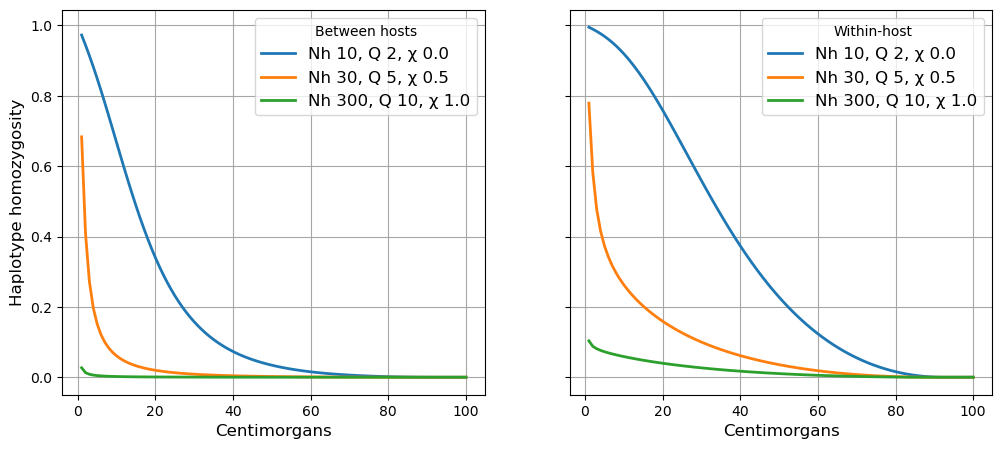

In [3]:
illustrative_histories = [
    [600, 10, 2, 0, 0],
    [1000, 30, 5, 0.5, 0],
    [10000, 300, 10, 1, 0]]

centimorgans = [x for x in range(1, 101)]   # range of haplotype lengths to be examined

fig, [a1, a2] = plt.subplots(1, 2, figsize = (12, 5), sharey = True)

for i,_ in enumerate(illustrative_histories):
    
    history = [illustrative_histories[i]]
    N = history[0][1]
    Q = history[0][2]
    X = history[0][3]
    
    my_pop = cs.Population(history)

    hap_length = []          # haplotype length in centimorgans
    beho_hap_hom = []        # between-host haplotype homozygosity
    wiho_hap_hom = []        # within-host haplotype homozygosity
    
    for j in range(len(centimorgans)):

        my_pop.get_coalescent(observe = 'auto', show = False)
        my_pop.locus_kb = centimorgans[j] * 13.5
        my_pop.get_diversity(show = False)
        
        hap_length.append(centimorgans[j])
        beho_hap_hom.append(my_pop.diversity[0, 3])   
        wiho_hap_hom.append(my_pop.diversity[0, 4])

    a1.plot(hap_length, beho_hap_hom, linewidth=2, label = 'Nh {0:.0f}, Q {1:.0f}, \u03C7 {2:.1f}'.format(N, Q, X))
    a2.plot(hap_length, wiho_hap_hom, linewidth=2, label = 'Nh {0:.0f}, Q {1:.0f}, \u03C7 {2:.1f}'.format(N, Q, X))
    
a1.set_xlabel("Centimorgans", fontsize=12)
a1.set_ylabel("Haplotype homozygosity", fontsize=12)
a1.legend(title = 'Between hosts', frameon=True, fontsize=12)
a1.grid(visible=True, which='both', color='0.65', linestyle='-')

a2.set_xlabel("Centimorgans", fontsize=12)
a2.legend(title = 'Within-host', frameon=True, fontsize=12)
a2.grid(visible=True, which='both', color='0.65', linestyle='-')

plt.show()
plt.show()